# Xgboost & Candlestick & pattern & return relationship

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import seaborn as sns
import os
from pathlib import Path
import pandas_ta as ta
import pspriceaction.price_action as pa
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [9]:
data = []
notebook_path = os.getcwd()
current_dir = Path(notebook_path)
algo_dir = current_dir.parent.parent
transform_csv_file = str(current_dir) + '/VN30F1M_5minutes_pattern.csv'
if os.path.isfile(transform_csv_file):
    data = pd.read_csv(transform_csv_file, index_col='Date', parse_dates=True)
    data['model'] = data['model'].fillna(value='')
else:
    csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
    is_file = os.path.isfile(csv_file)
    if is_file:
        dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
    else:
        dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)
    data = dataset.copy()
    data = pa.pattern_modeling(data)
    data.to_csv(transform_csv_file)

### Candlstick wick & tail

In [10]:
data['upper_wick'] = data.apply(
    lambda r: r['High'] - max(r['Open'], r['Close']), axis=1)
data['tail'] = data.apply(
    lambda r: min(r['Open'], r['Close']) - r['Low'], axis=1)
data['upper_wick'] = data['upper_wick'].round(1)
data['tail'] = data['tail'].round(1)

### Calculating return

In [11]:
def has_bullish_pattern(model):
    if "bullish" in model or "rising" in model:
        return True
    return False

def has_bearish_pattern(model):
    if "bearish" in model or "falling" in model:
        return True
    return False

In [12]:
%%time
data['return'] = ''
data['signal'] = ''
data['exit_time'] = ''
# Stoploss at x0 pips
sl_step = 3
# Takeprofit at y0 pips(R/R = 1/3)
tp_step = 9
for i, row in data.iterrows():
    if has_bullish_pattern(row['model']):
        # Long signal
        data.at[i, 'signal'] = 'long'
        current_date = row.name.strftime('%Y-%m-%d ').format()
        current_time = row.name
        entry_price = row['Close']
        data_to_end_day = data[(data.index > current_time) & (data.index < current_date+' 14:30:00')]
        max_price = 0
        exit_time = ''
        for k, wrow in data_to_end_day.iterrows():
            if wrow['Low'] < entry_price and wrow['Low'] < entry_price - sl_step:
                # Stop loss
                momentum = -sl_step
                exit_time = wrow.name
                break
            else:
                if wrow['High'] > entry_price + tp_step:
                    # Take profit
                    momentum = tp_step
                    exit_time = wrow.name
                    break
                else:
                    # Close at 02:25PM
                    momentum = wrow['Close'] - entry_price
                    exit_time = wrow.name
        data.at[i, 'return'] = momentum
        data.at[i, 'exit_time'] = exit_time
    elif has_bearish_pattern(row['model']):
        # Short signal
        data.at[i, 'signal'] = 'short'
        current_date = row.name.strftime('%Y-%m-%d ').format()
        current_time = row.name
        entry_price = row['Close']
        data_to_end_day = data[(data.index > current_time) & (data.index < current_date+' 14:30:00')]
        min_price = 10000
        exit_time = ''
        for k, wrow in data_to_end_day.iterrows():
            if wrow['High'] > entry_price and wrow['High'] > entry_price + sl_step:
                # Stop loss
                momentum = -sl_step
                exit_time = wrow.name
                break
            else:
                if wrow['Low'] < entry_price - tp_step:
                    # Take profit
                    momentum = tp_step
                    exit_time = wrow.name
                    break
                else:
                    # Close at 02:25PM
                    momentum = entry_price - wrow['Close']
                    exit_time = wrow.name
        data.at[i, 'return'] = momentum
        data.at[i, 'exit_time'] = exit_time

CPU times: user 18.1 s, sys: 365 μs, total: 18.1 s
Wall time: 18.1 s


### Return Analytics

In [13]:
has_return = data[data['return'] != '']
#----
long_return = has_return[has_return['signal'] == 'long']
short_return = has_return[has_return['signal'] == 'short']
#----
negative_return = has_return[has_return['return'] < 0]
positive_return = has_return[has_return['return'] > 0]
#----
short_negative_return = short_return[short_return['return'] < 0]
short_positive_return = short_return[short_return['return'] > 0]
long_negative_return = long_return[long_return['return'] < 0]
long_positive_return = long_return[long_return['return'] > 0]

### Wick & tail & return relationship

In [14]:
# k = long_return.groupby(['tail'])[['tail']].count()
# with pd.option_context('display.max_rows', None,
#                        'display.max_columns', None,
#                        'display.precision', 3,
#                        ):
#     print(k)

In [15]:
crop_long_return = long_return[(long_return['tail'] < 2.6) & (long_return.upper_wick <= 4)]
crop_long_return['wick_group'] = pd.cut(crop_long_return['upper_wick'], 20)
crop_long_return['tail_group'] = pd.cut(crop_long_return['tail'], 13)
# sum return of wick_tail group of long
lsg = crop_long_return.groupby(['wick_group', 'tail_group'])[['return']].sum()
lsg = lsg.reset_index()
lsg_pivot = lsg.pivot(index="wick_group", columns="tail_group", values="return").sort_index(ascending=False)
lsg_pivot = lsg_pivot[lsg_pivot.columns].astype(float)

In [16]:
lsg_pivot

tail_group,"(-0.0025, 0.192]","(0.192, 0.385]","(0.385, 0.577]","(0.577, 0.769]","(0.769, 0.962]","(0.962, 1.154]","(1.154, 1.346]","(1.346, 1.538]","(1.538, 1.731]","(1.731, 1.923]","(1.923, 2.115]","(2.115, 2.308]","(2.308, 2.5]"
wick_group,,,,,,,,,,,,,
"(3.8, 4.0]",5.7,-3.0,-9.0,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.0,0.0,0.0
"(3.6, 3.8]",14.3,0.0,15.0,0.0,-3.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0
"(3.4, 3.6]",0.8,0.0,-3.0,0.0,-3.0,9.0,0.0,0.0,-3.0,0.0,0.0,0.0,0.0
"(3.2, 3.4]",-4.6,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(3.0, 3.2]",-20.0,6.0,0.0,9.0,-3.0,0.0,0.0,-3.0,9.0,0.0,0.0,0.0,0.0
"(2.8, 3.0]",16.1,0.0,-5.1,0.0,-3.0,9.0,-3.0,0.0,-3.0,0.0,0.0,0.0,0.0
"(2.6, 2.8]",27.9,5.0,-15.0,-3.0,1.2,-3.0,0.0,0.0,0.0,-3.0,0.0,0.0,0.0
"(2.4, 2.6]",15.0,-15.0,6.0,-0.9,6.0,0.0,0.0,0.0,0.0,0.0,-3.0,-3.0,0.0
"(2.2, 2.4]",12.1,6.0,0.4,15.8,-12.0,-3.0,0.0,6.0,-6.0,0.0,-3.0,-3.0,0.0


<Axes: xlabel='tail_group', ylabel='wick_group'>

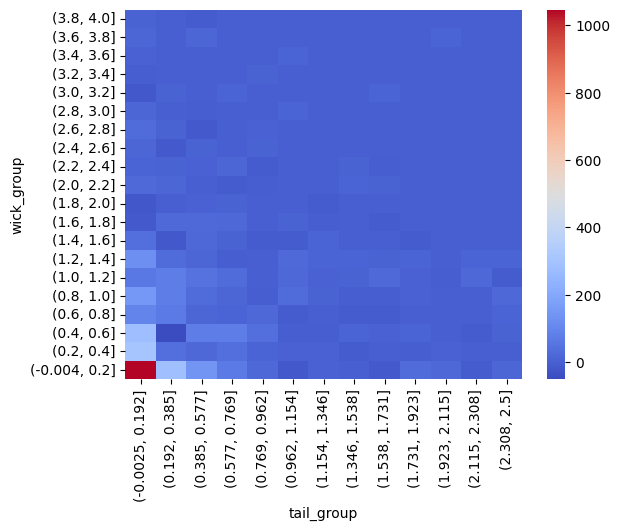

In [18]:
sns.heatmap(lsg_pivot, cmap = 'coolwarm')

In [20]:
crop_long_return['return_group'] = crop_long_return.apply(lambda r: 1 if r['return'] > 0 else 0, axis=1)

In [23]:
crop_long_return['return_group'].describe()

count    6244.000000
mean        0.401826
std         0.490306
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: return_group, dtype: float64

In [27]:
crop_long_return

,Open,High,Low,Close,model,upper_wick,tail,return,signal,exit_time,wick_group,tail_group,return_group
Date,,,,,,,,,,,,,
2018-08-13 09:55:00,946.2,946.4,945.6,946.0,bullish_neck,0.2,0.4,-3,long,2018-08-13 10:45:00,"(-0.004, 0.2]","(0.385, 0.577]",0
2018-08-13 11:10:00,944.9,946.1,944.6,946.1,fair_value_rising_gap,0.0,0.3,8.0,long,2018-08-13 14:25:00,"(-0.004, 0.2]","(0.192, 0.385]",1
2018-08-13 11:30:00,947.1,947.3,947.1,947.3,"bullish_gap, fair_value_rising_gap",0.0,0.0,6.8,long,2018-08-13 14:25:00,"(-0.004, 0.2]","(-0.0025, 0.192]",1
2018-08-13 13:40:00,948.2,949.6,948.2,948.8,fair_value_rising_gap,0.8,0.0,5.3,long,2018-08-13 14:25:00,"(0.6, 0.8]","(-0.0025, 0.192]",1
2018-08-13 14:30:00,954.1,954.2,954.1,954.2,fair_value_rising_gap,0.0,0.0,5.3,long,,"(-0.004, 0.2]","(-0.0025, 0.192]",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-18 14:25:00,1296.0,1298.1,1296.0,1297.7,fair_value_rising_gap,0.4,0.0,-3,long,,"(0.2, 0.4]","(-0.0025, 0.192]",0
2024-07-18 14:30:00,1297.7,1297.8,1297.7,1297.8,fair_value_rising_gap,0.0,0.0,-3,long,,"(-0.004, 0.2]","(-0.0025, 0.192]",0
2024-07-19 09:25:00,1303.2,1309.1,1303.2,1309.0,rising_three,0.1,0.0,-3,long,2024-07-19 10:20:00,"(-0.004, 0.2]","(-0.0025, 0.192]",0


### Apply machine learning

In [24]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [29]:
le = LabelEncoder()
crop_long_return['model'] = crop_long_return[['model']].apply(le.fit_transform)
crop_long_return

,Open,High,Low,Close,model,upper_wick,tail,return,signal,exit_time,wick_group,tail_group,return_group
Date,,,,,,,,,,,,,
2018-08-13 09:55:00,946.2,946.4,945.6,946.0,5,0.2,0.4,-3,long,2018-08-13 10:45:00,"(-0.004, 0.2]","(0.385, 0.577]",0
2018-08-13 11:10:00,944.9,946.1,944.6,946.1,7,0.0,0.3,8.0,long,2018-08-13 14:25:00,"(-0.004, 0.2]","(0.192, 0.385]",1
2018-08-13 11:30:00,947.1,947.3,947.1,947.3,2,0.0,0.0,6.8,long,2018-08-13 14:25:00,"(-0.004, 0.2]","(-0.0025, 0.192]",1
2018-08-13 13:40:00,948.2,949.6,948.2,948.8,7,0.8,0.0,5.3,long,2018-08-13 14:25:00,"(0.6, 0.8]","(-0.0025, 0.192]",1
2018-08-13 14:30:00,954.1,954.2,954.1,954.2,7,0.0,0.0,5.3,long,,"(-0.004, 0.2]","(-0.0025, 0.192]",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-18 14:25:00,1296.0,1298.1,1296.0,1297.7,7,0.4,0.0,-3,long,,"(0.2, 0.4]","(-0.0025, 0.192]",0
2024-07-18 14:30:00,1297.7,1297.8,1297.7,1297.8,7,0.0,0.0,-3,long,,"(-0.004, 0.2]","(-0.0025, 0.192]",0
2024-07-19 09:25:00,1303.2,1309.1,1303.2,1309.0,9,0.1,0.0,-3,long,2024-07-19 10:20:00,"(-0.004, 0.2]","(-0.0025, 0.192]",0


In [30]:
 # split dataset in features and target variable
feature_cols = ["model", "upper_wick", "tail"]
X = crop_long_return[feature_cols]  # Features
y = crop_long_return['return_group'] # Target variable
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)  # 80% training and 20% test

In [31]:
import xgboost as xgb
# Create XGBClassifier model
model_xgb = xgb.XGBClassifier(n_estimators=100, random_state=42)

# Train XGBClassifier
model_xgb = model_xgb.fit(X_train, y_train)

In [32]:
# Predict the response for test dataset
y_pred = model_xgb.predict(X_test)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("R2_score:", metrics.r2_score(y_test, y_pred))

Accuracy: 0.5836669335468375
R2_score: -0.7581644144144146


In [33]:
X_result = X_test.copy()
X_result = X_result.assign(Predicts=y_pred)
X_result = X_result[['Predicts']]
crop_long_return = pd.merge(crop_long_return, X_result, left_index=True, right_index=True, how="left")
crop_long_return.dropna(inplace=True)
crop_long_return

,Open,High,Low,Close,model,upper_wick,tail,return,signal,exit_time,wick_group,tail_group,return_group,Predicts
Date,,,,,,,,,,,,,,
2023-05-09 09:55:00,1045.0,1045.3,1044.9,1045.3,7,0.0,0.1,-3,long,2023-05-09 13:10:00,"(-0.004, 0.2]","(-0.0025, 0.192]",0,1.0
2023-05-09 13:05:00,1042.7,1043.0,1042.5,1042.8,0,0.2,0.2,-0.5,long,2023-05-09 14:25:00,"(-0.004, 0.2]","(0.192, 0.385]",0,0.0
2023-05-09 13:25:00,1043.2,1043.2,1042.6,1042.9,5,0.0,0.3,-0.6,long,2023-05-09 14:25:00,"(-0.004, 0.2]","(0.192, 0.385]",0,0.0
2023-05-10 09:10:00,1043.8,1044.0,1043.6,1043.9,2,0.1,0.2,7.6,long,2023-05-10 14:25:00,"(-0.004, 0.2]","(0.192, 0.385]",1,0.0
2023-05-10 09:45:00,1045.3,1045.5,1045.0,1045.2,5,0.2,0.2,6.3,long,2023-05-10 14:25:00,"(-0.004, 0.2]","(0.192, 0.385]",1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-18 14:25:00,1296.0,1298.1,1296.0,1297.7,7,0.4,0.0,-3,long,,"(0.2, 0.4]","(-0.0025, 0.192]",0,0.0
2024-07-18 14:30:00,1297.7,1297.8,1297.7,1297.8,7,0.0,0.0,-3,long,,"(-0.004, 0.2]","(-0.0025, 0.192]",0,1.0
2024-07-19 09:25:00,1303.2,1309.1,1303.2,1309.0,9,0.1,0.0,-3,long,2024-07-19 10:20:00,"(-0.004, 0.2]","(-0.0025, 0.192]",0,0.0
